# Loading data and creating dataframe

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm


In [ ]:
def extract_features(image_path):
    image = cv2.imread(image_path)

    # raspodela slike i sracunavanje
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    color_hist = color_hist.flatten()  # Flatten the histogram

    # osvetljenje
    brightness = np.mean(image)

    # broj kontura
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)

    return color_hist, brightness, num_contours

# pravimo dataframe
columns = ['color_hist_' + str(i) for i in range(512)] + ['brightness', 'num_contours', 'emotion']
df = pd.DataFrame(columns=columns)

In [4]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


for emotion in emotions:
    folder_path = os.path.join('data/original_faces', emotion)
    image_ids = os.listdir(folder_path)[:100]  # Process only the first 100 images

    for image_id in tqdm(image_ids):
        image_name = os.path.join(folder_path, image_id)
        color_hist, brightness, num_contours = extract_features(image_name)

        features = list(color_hist) + [brightness, num_contours, emotion]

        df.loc[len(df)] = features      


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.86it/s]


In [6]:
df.drop(columns=[f'color_hist_{i}' for i in range(1, 511)], inplace=True)

In [10]:
df.head()

,color_hist_0,color_hist_511,brightness,num_contours,emotion
0,550.0,40.0,108.808955,60,anger
1,516.0,344.0,118.175745,53,anger
2,1215.0,579.0,109.270906,47,anger
3,2648.0,956.0,120.741645,57,anger
4,100.0,1460.0,166.495226,74,anger


# Visualistaion

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Ovde definisem neke vizuelizacije za datafrejm koji imamo

def get_random_color():
    return tuple(np.random.rand(3))

def plot_histograms(df):
    emotions = df['emotion'].unique()
    num_bins = 20

    for emotion in emotions:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        color = get_random_color()
        axs[0].hist(df[df['emotion'] == emotion]['brightness'], bins=num_bins, alpha=0.5, color=color)
        axs[1].hist(df[df['emotion'] == emotion]['num_contours'], bins=num_bins, alpha=0.5, color=color)
        axs[2].hist(df[df['emotion'] == emotion]['color_hist_0'], bins=num_bins, alpha=0.5, color=color)

        axs[0].set_title('Brightness Distribution - ' + emotion)
        axs[1].set_title('Num_contours Distribution - ' + emotion)
        axs[2].set_title('Color Histogram Distribution - ' + emotion)

        plt.tight_layout()
        plt.show()



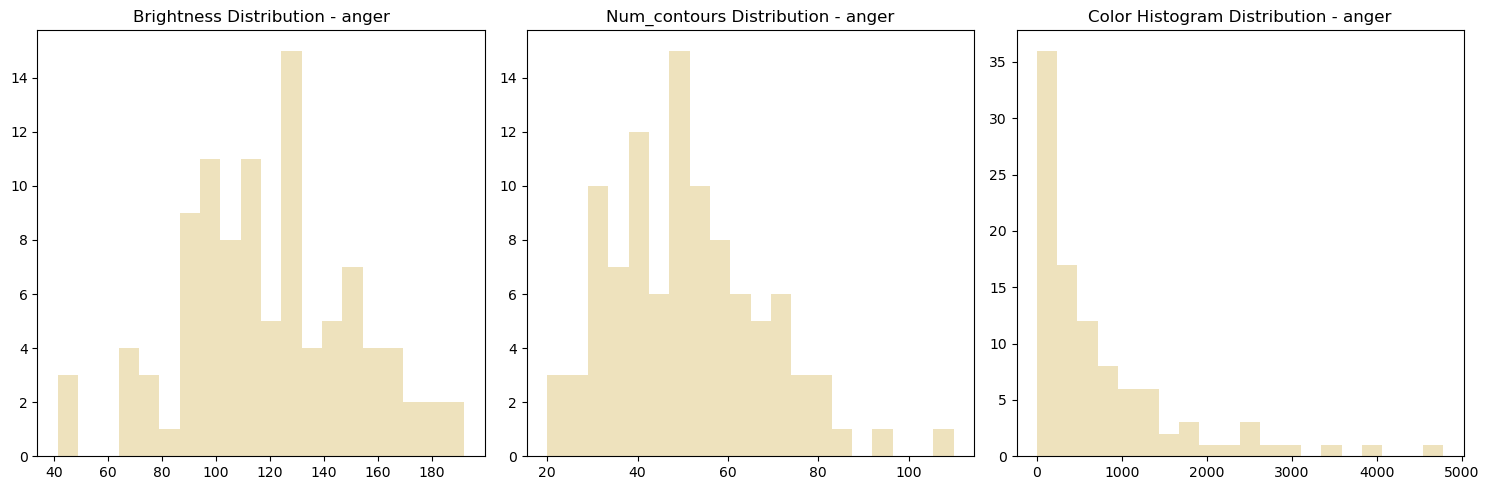

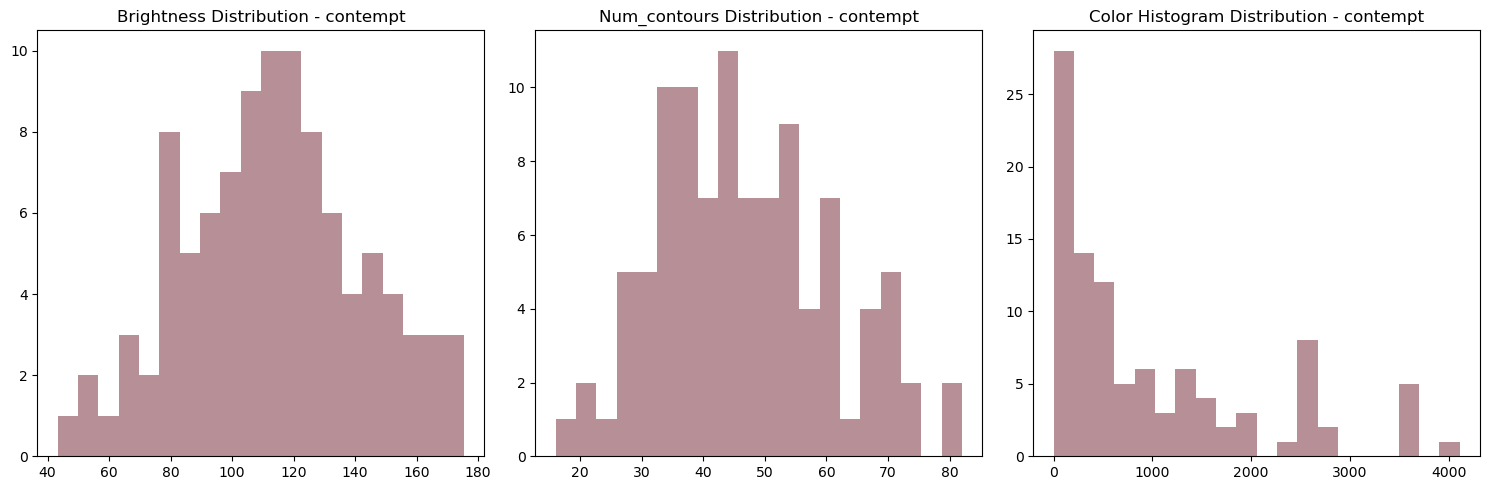

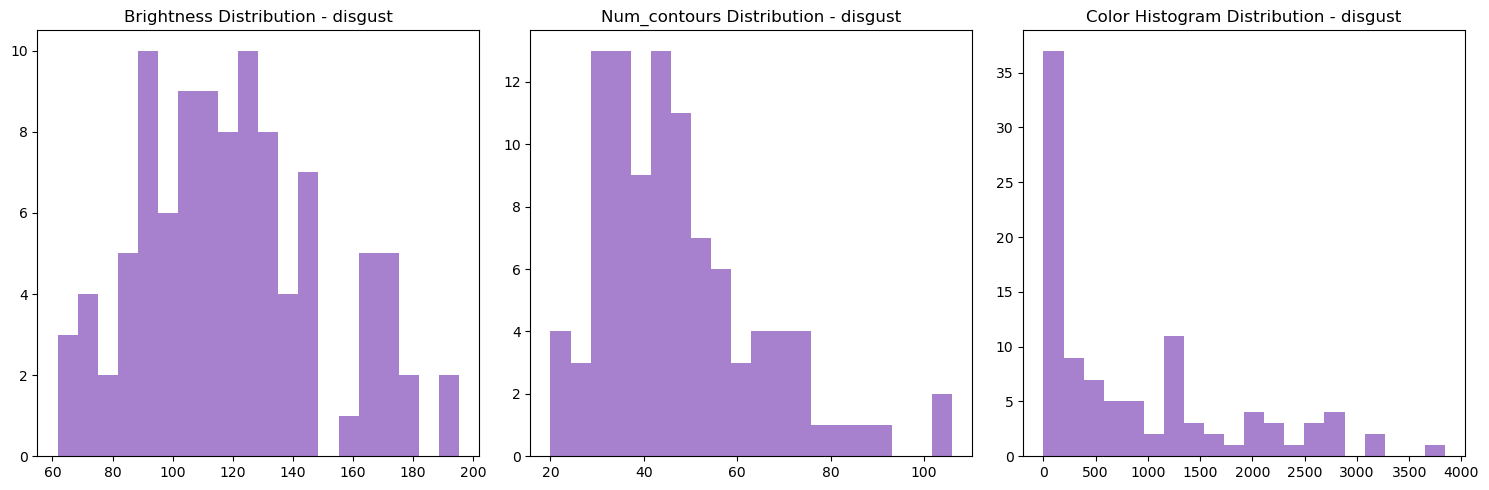

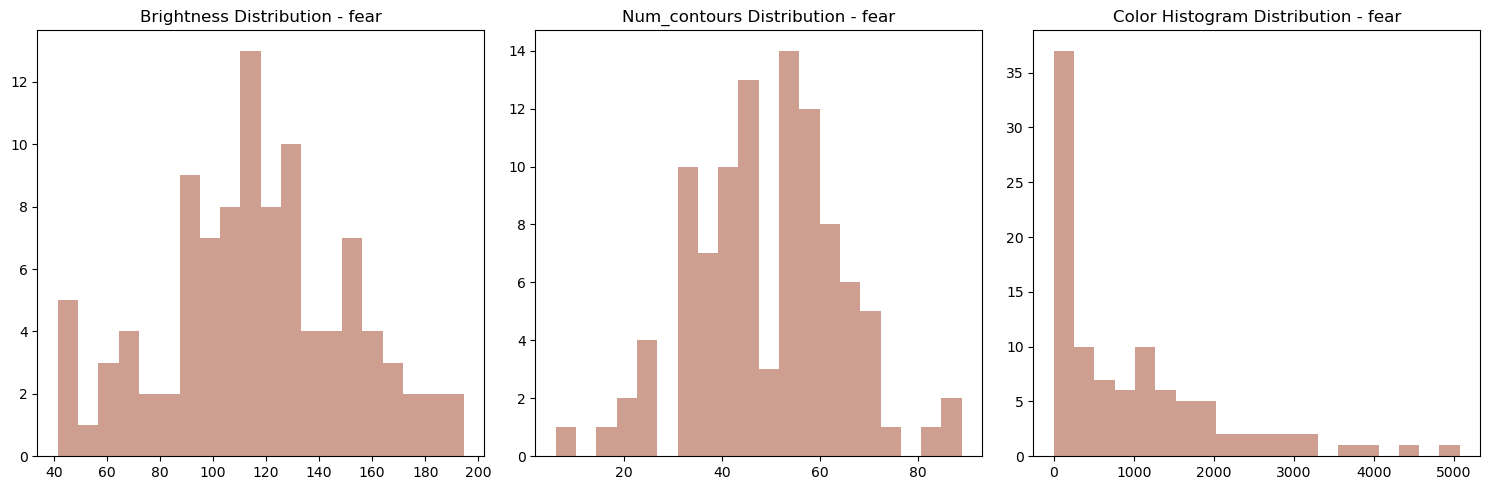

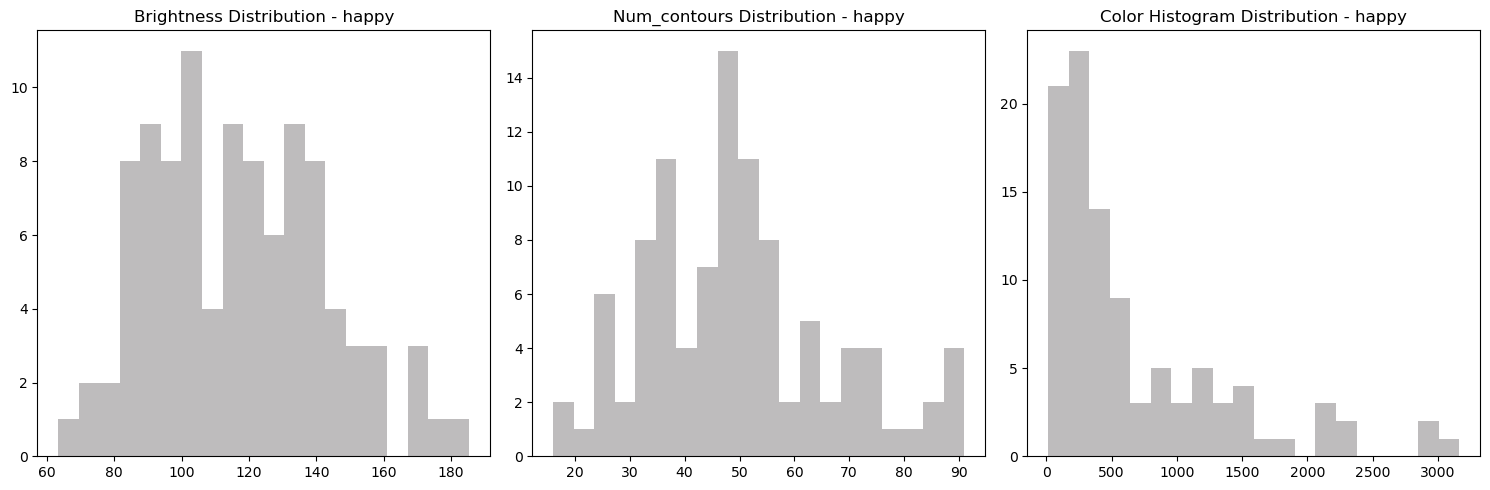

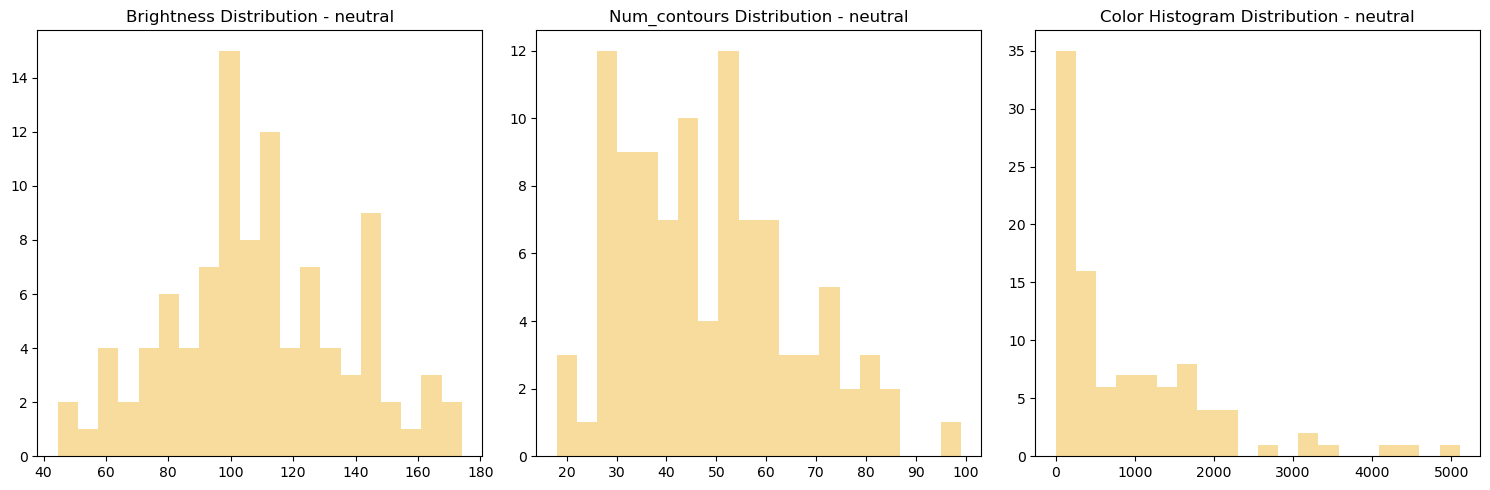

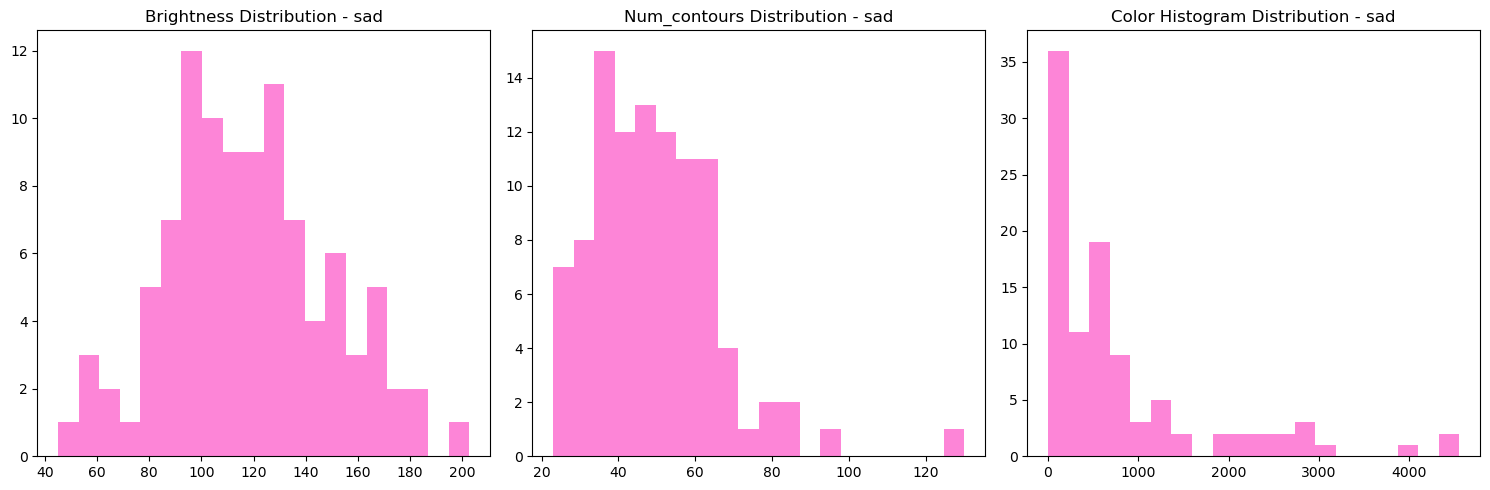

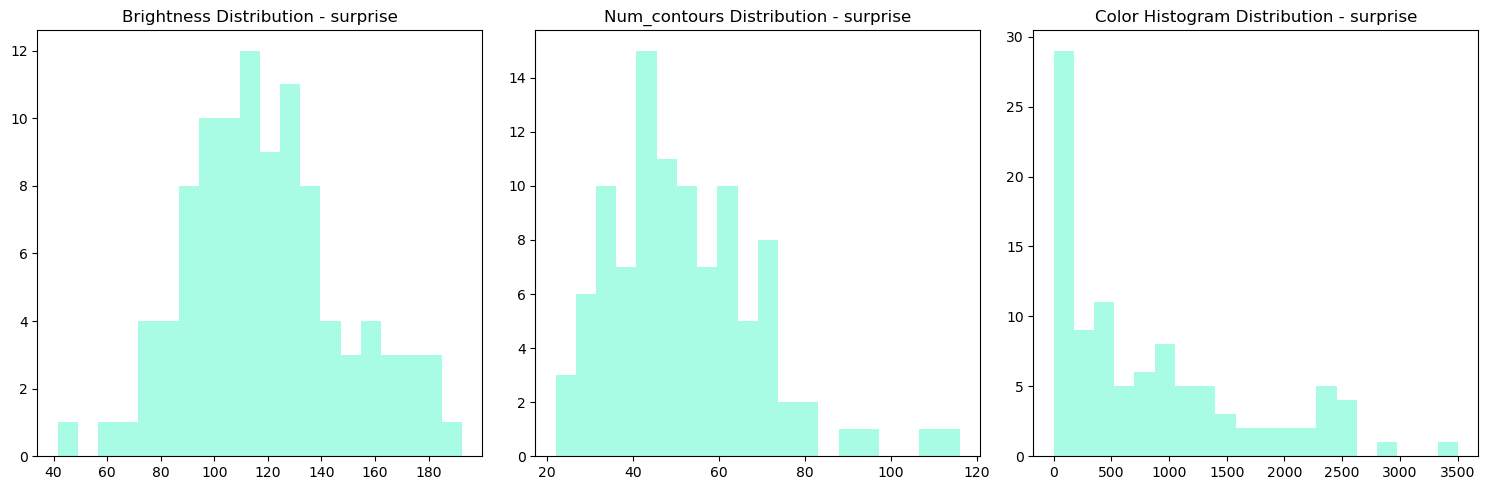

In [14]:
plot_histograms(df)

Razlike su definitivno prisutne medju grupama emocija sto se tice raspodele po ostalim kolonama, to je zanimljivo! Hajde da vidimo da li je taj zakljucak verodostojan van okrilja vizuelne pretpostavke.

In [21]:
def plot_boxplots(df):
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df, x='emotion', y='brightness', hue = 'emotion', legend =  False)
    plt.title('Brightness Box Plot by Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('Brightness')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


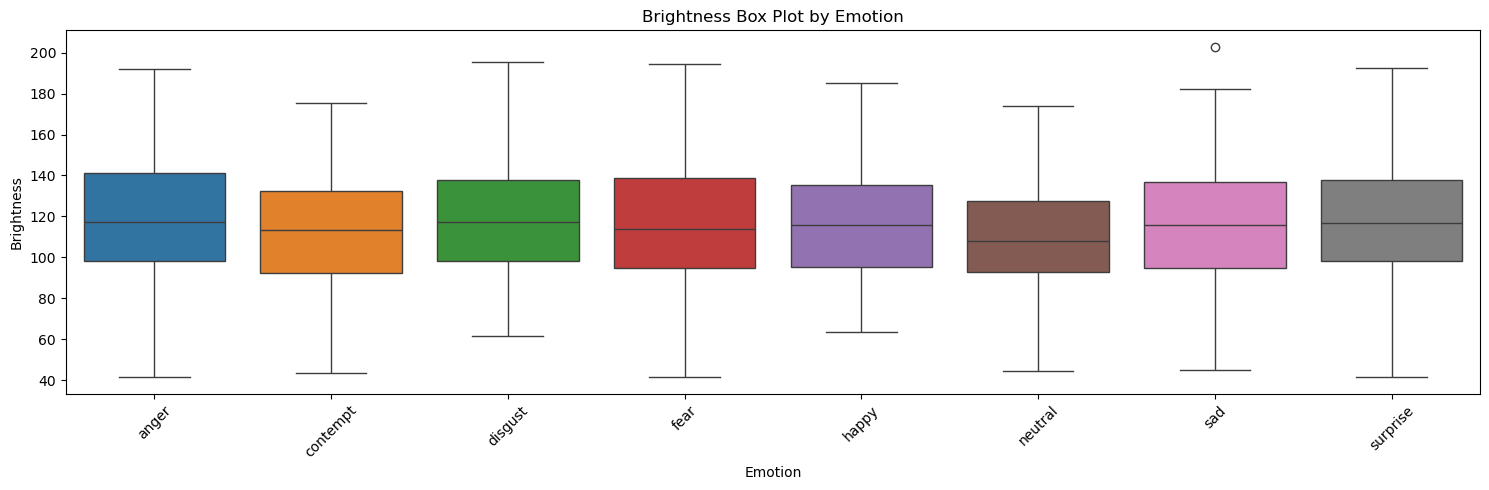

In [22]:
plot_boxplots(df)

In [24]:
def plot_scatter(df):
    plt.figure(figsize=(12, 10))
    emotions = df['emotion'].unique()

    for emotion in emotions:
        color = get_random_color()
        sns.scatterplot(data=df[df['emotion'] == emotion], x='brightness', y='num_contours', hue='emotion', palette=[color])

    plt.title('Scatter Plot: Brightness vs Num_contours')
    plt.show()

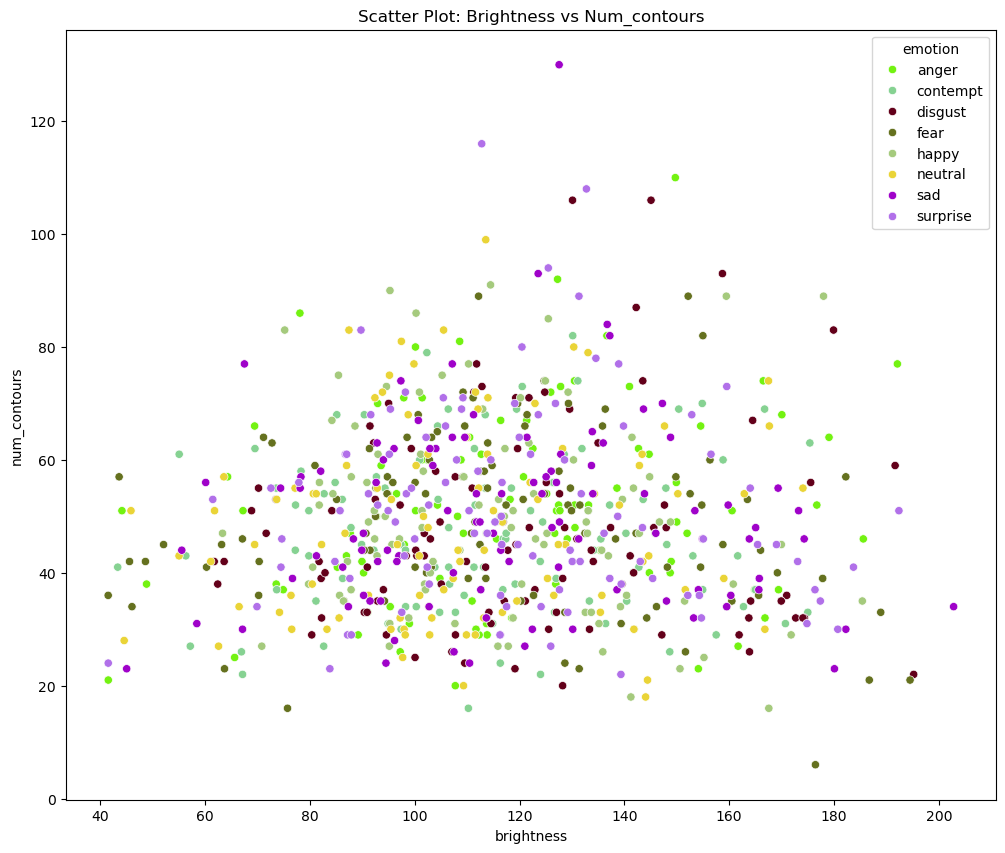

In [25]:
plot_scatter(df)

In [26]:
def plot_bar_chart(df):
    plt.figure(figsize=(10, 5))
    emotions = df['emotion'].unique()

    for emotion in emotions:
        color = get_random_color()
        sns.barplot(data=df[df['emotion'] == emotion], x='emotion', y='brightness', color=color)

    plt.title('Average Brightness by Emotion')
    plt.show()

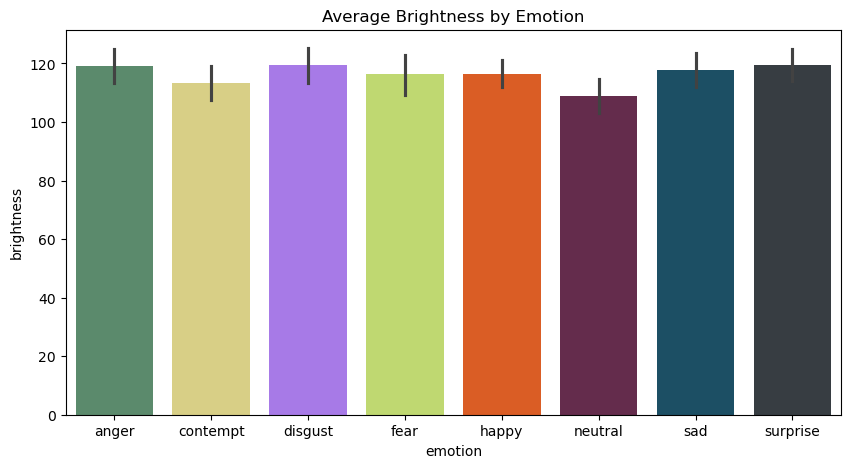

In [27]:
plot_bar_chart(df)

In [28]:
def plot_heatmap(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.drop(columns=['emotion'], axis=1).corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()


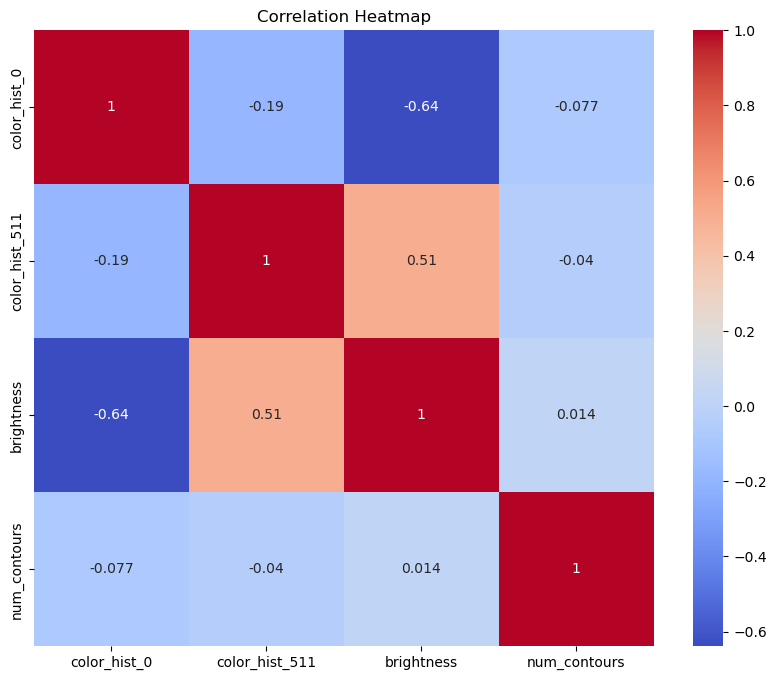

In [18]:
plot_heatmap(df)

In [12]:
def plot_pairplots(df):
    emotions = df['emotion'].unique()

    for emotion in emotions:
        subset = df[df['emotion'] == emotion]
        plt.figure(figsize=(10, 8))
        sns.pairplot(subset, height=2.5)
        plt.suptitle('Pairplot for ' + emotion, fontsize=16)
        plt.show()

In [29]:
# plot_pairplots(df)

# Statistical tests

In [ ]:
from scipy.stats import skew, kurtosis

def calculate_statistics(image):
    mean = np.mean(image)
    std_dev = np.std(image)
    skewness = skew(image.ravel())
    kurt = kurtosis(image.ravel())
    return mean, std_dev, skewness, kurt

# Example usage
mean, std_dev, skewness, kurt = calculate_statistics(image)


In [20]:
from scipy.stats import f_oneway, kruskal, chi2_contingency

anova_result = f_oneway(*[group['num_contours'] for name, group in df.groupby('emotion')])
print("ANOVA Test for num_contours:")
print(anova_result)

kruskal_result = kruskal(*[group['brightness'] for name, group in df.groupby('emotion')])
print("\nKruskal-Wallis H-test for brightness:")
print(kruskal_result)

ANOVA Test for num_contours:
F_onewayResult(statistic=1.0552432516138401, pvalue=0.39084330676246465)

Kruskal-Wallis H-test for brightness:
KruskalResult(statistic=8.934091760299907, pvalue=0.25742270598443784)


According to the ANOVA and Kruskal-Wallis tests, we can conclude that there are no statistically significant differences between the mean values for the number of countours and brightness across images of different emotions